In [3]:
!python -m venv myenv

In [2]:
%pip install -r requirements.txt

  Using cached charset_normalizer-3.4.2-cp311-cp311-win_amd64.whl (105 kB)
  Using cached contourpy-1.3.2-cp311-cp311-win_amd64.whl (222 kB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached filelock-3.18.0-py3-none-any.whl (16 kB)
  Using cached fonttools-4.58.0-cp311-cp311-win_amd64.whl (2.2 MB)
  Using cached fsspec-2025.5.1-py3-none-any.whl (199 kB)
  Using cached idna-3.10-py3-none-any.whl (70 kB)
  Using cached ipython-9.1.0-py3-none-any.whl (604 kB)
  Using cached joblib-1.5.0-py3-none-any.whl (307 kB)
  Using cached jupyter_core-5.7.2-py3-none-any.whl (28 kB)
  Using cached kiwisolver-1.4.8-cp311-cp311-win_amd64.whl (71 kB)
  Using cached MarkupSafe-3.0.2-cp311-cp311-win_amd64.whl (15 kB)
  Using cached matplotlib-3.10.3-cp311-cp311-win_amd64.whl (8.1 MB)
  Using cached networkx-3.5-py3-none-any.whl (2.0 MB)
  Using cached numpy-2.2.5-cp311-cp311-win_amd64.whl (12.9 MB)
  Using cached pandas-2.2.3-cp311-cp311-win_amd64.whl (11.6 MB)
  Using cached pillow-11.


[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/LaBSE')

sentences = ["A cat sitting on a mat", "بلی چٹائی پر بیٹھی ہے"]  # Urdu translation
embeddings = model.encode(sentences)

from sklearn.metrics.pairwise import cosine_similarity
print("Similarity:", cosine_similarity([embeddings[0]], [embeddings[1]]))


c:\Users\Lab\Desktop\KDD\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Similarity: [[0.8460823]]


c:\Users\Lab\Desktop\KDD\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


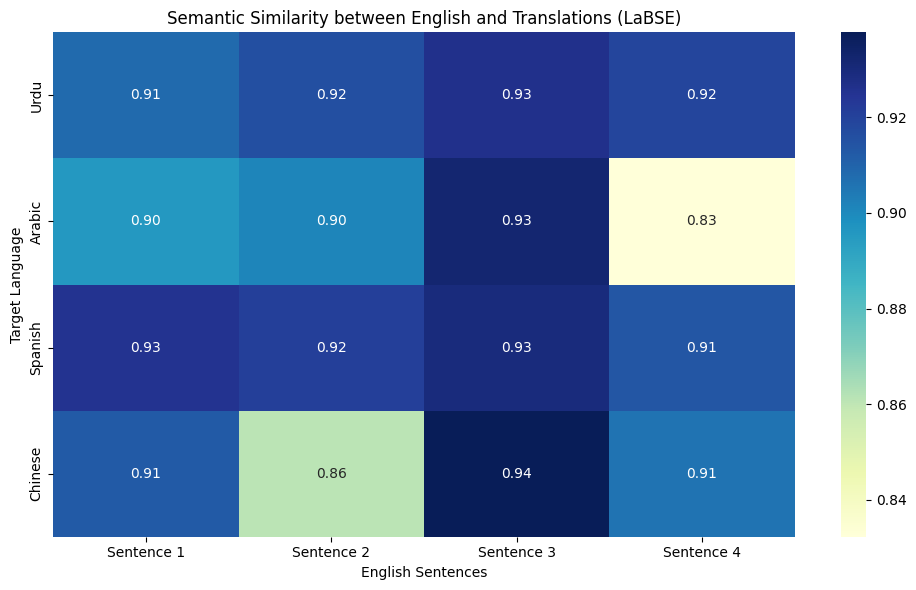

In [1]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from googletrans import Translator
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- Step 1: Setup ----------
model = SentenceTransformer('sentence-transformers/LaBSE')
translator = Translator()

english_sentences = [
    "A man is playing guitar on the street.",
    "A group of children are playing in the park.",
    "A woman is riding a bicycle near the beach.",
    "A cat is sleeping on the couch."
]

target_languages = {
    'Urdu': 'ur',
    'Arabic': 'ar',
    'Spanish': 'es',
    'Chinese': 'zh-cn'
}

# ---------- Step 2: Translation ----------
translated_sentences = {lang: [] for lang in target_languages}

for sentence in english_sentences:
    for lang, code in target_languages.items():
        translation = translator.translate(sentence, dest=code)
        translated_sentences[lang].append(translation.text)

# ---------- Step 3: Embedding & Similarity ----------
results = {}
for lang in target_languages:
    similarities = []
    for en, tr in zip(english_sentences, translated_sentences[lang]):
        embeddings = model.encode([en, tr])
        sim = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
        similarities.append(sim)
    results[lang] = similarities

# ---------- Step 4: Visualization ----------
plt.figure(figsize=(10, 6))
sns.heatmap(
    [results[lang] for lang in results],
    xticklabels=[f"Sentence {i+1}" for i in range(len(english_sentences))],
    yticklabels=list(results.keys()),
    cmap='YlGnBu',
    annot=True,
    fmt=".2f"
)

plt.title("Semantic Similarity between English and Translations (LaBSE)")
plt.xlabel("English Sentences")
plt.ylabel("Target Language")
plt.tight_layout()
plt.show()


Processing Captions: 100%|██████████| 10/10 [00:19<00:00,  2.00s/it]


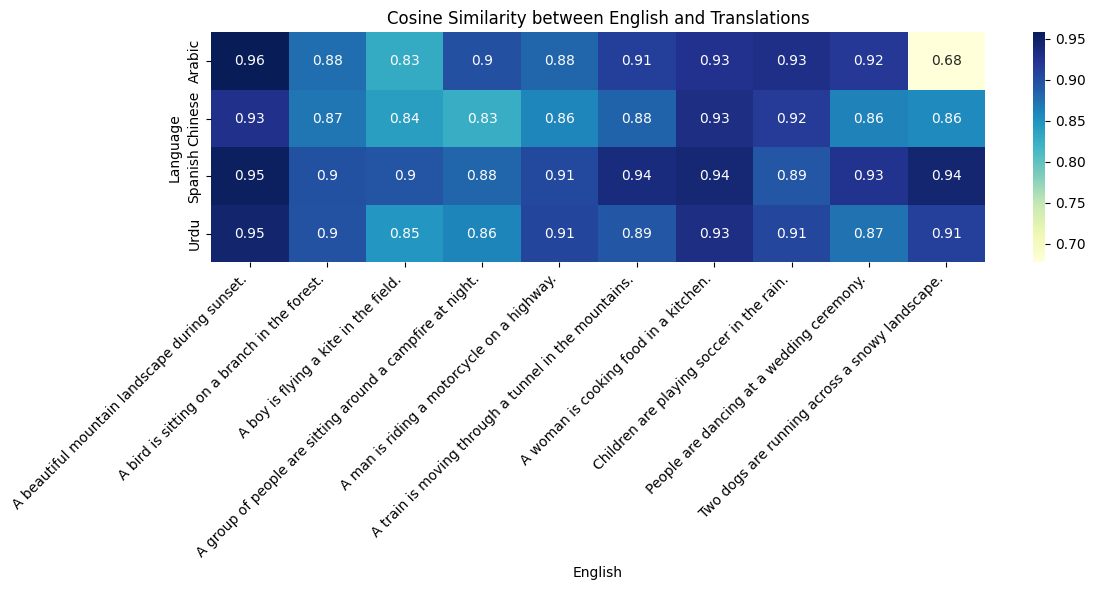

C:\Users\Lab\AppData\Local\Temp\ipykernel_16248\2211528567.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Language", y="Token_Diff", palette="coolwarm")


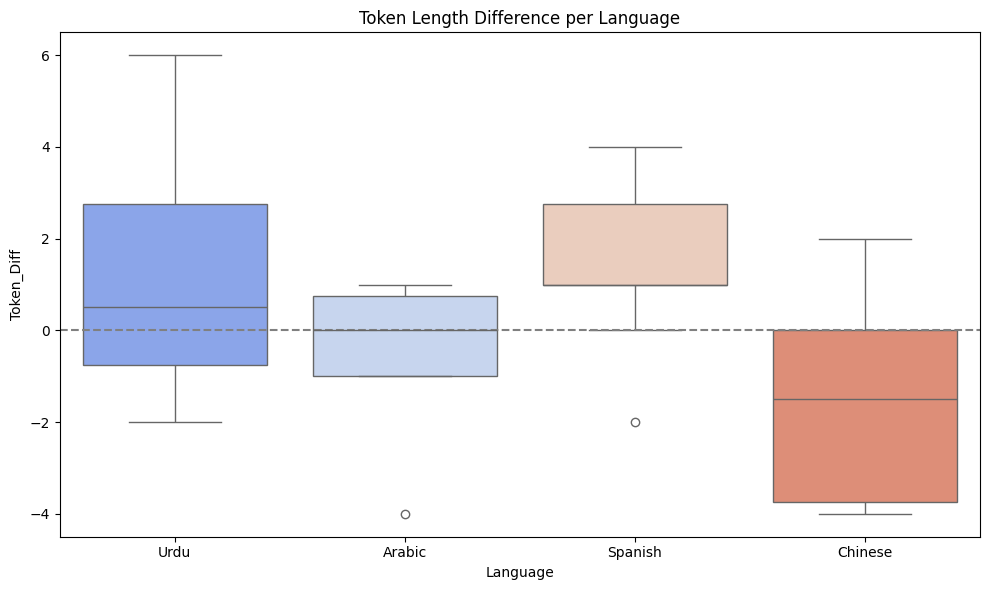

In [3]:
from transformers import XLMRobertaTokenizer
from sentence_transformers import SentenceTransformer
from googletrans import Translator
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

# ---------- Setup ----------
xlmr_tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
labse_model = SentenceTransformer('sentence-transformers/LaBSE')
translator = Translator()

languages = {
    'Urdu': 'ur',
    'Arabic': 'ar',
    'Spanish': 'es',
    'Chinese': 'zh-cn'
}

# MS-COCO-like sample captions
english_captions = [
    "A boy is flying a kite in the field.",
    "Two dogs are running across a snowy landscape.",
    "A woman is cooking food in a kitchen.",
    "A group of people are sitting around a campfire at night.",
    "A man is riding a motorcycle on a highway.",
    "Children are playing soccer in the rain.",
    "A beautiful mountain landscape during sunset.",
    "A bird is sitting on a branch in the forest.",
    "People are dancing at a wedding ceremony.",
    "A train is moving through a tunnel in the mountains."
]

# ---------- Translation, Tokenization, Embedding ----------
report_data = []

for sentence in tqdm(english_captions, desc="Processing Captions"):
    en_tokens = len(xlmr_tokenizer.tokenize(sentence))
    en_embedding = labse_model.encode([sentence])[0]

    for lang_name, lang_code in languages.items():
        try:
            translated = translator.translate(sentence, dest=lang_code).text
            tr_tokens = len(xlmr_tokenizer.tokenize(translated))
            tr_embedding = labse_model.encode([translated])[0]
            similarity = cosine_similarity([en_embedding], [tr_embedding])[0][0]

            report_data.append({
                "English": sentence,
                "Language": lang_name,
                "Translated": translated,
                "EN_Tokens": en_tokens,
                "TR_Tokens": tr_tokens,
                "Token_Diff": tr_tokens - en_tokens,
                "Cosine_Similarity": round(float(similarity), 4)
            })
        except Exception as e:
            print(f"Error with {lang_name} translation: {e}")

# ---------- Export as CSV ----------
df = pd.DataFrame(report_data)
df.to_csv("multilingual_semantic_report.csv", index=False)

# ---------- Save JSONL (Optional) for T2I or Dataset Training ----------
with open("multilingual_dataset.jsonl", "w", encoding="utf-8") as f:
    for row in report_data:
        f.write(json.dumps(row, ensure_ascii=False) + "\n")

# ---------- Visualization ----------
plt.figure(figsize=(12, 6))
sns.heatmap(df.pivot(index="Language", columns="English", values="Cosine_Similarity"), annot=True, cmap="YlGnBu")
plt.title("Cosine Similarity between English and Translations")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("similarity_heatmap.png")
plt.show()

# Token difference trend
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="Language", y="Token_Diff", palette="coolwarm")
plt.title("Token Length Difference per Language")
plt.axhline(0, linestyle='--', color='gray')
plt.tight_layout()
plt.savefig("token_diff_boxplot.png")
plt.show()
